# Background
Coca-Cola launched four new Diet Coke flavors in January 2018: Ginger Lime, Feisty Cherry, Zesty Blood Orange, and Twisted Mango. The new flavors were accompanied by modernized packaging and a new ad campaign. Due to stagnation in sales with Millennials, Diet Coke sought to use this campaign as a way to attract Millennial attention.
The account team has asked the analytics team to perform a series of analysis to determine the effectiveness of the campaign. This includes but is not limited to: identifying areas of improvement, determining whether the target audience was reached, and evaluating how well their set of product influencers performed.


As a data analyst, you are asked to use python(2or3) to perform the following data analysis to support business team. Your final deliverables will include: spreadsheet(csv) files reflecting all the work you would have done and notebooks with your code to generate the csv files.

### Import package

In [1]:
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import re
import warnings
import nltk
from nltk import sent_tokenize
import collections
warnings.filterwarnings('ignore')
%matplotlib inline

### Read and clean data

In [2]:
reader = pd.read_csv('Diet_Coke_Raw_Data.csv',sep="`",low_memory=False)

In [3]:
df=reader

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1492805 entries, 0 to 1492846
Data columns (total 18 columns):
Author                 1490698 non-null object
Blog_Comments          1492782 non-null object
Date                   1492782 non-null object
Facebook_Comments      1492782 non-null object
Facebook_Likes         1492780 non-null object
Full_Text              1492782 non-null object
Instagram_Comments     1492650 non-null object
Instagram_Followers    1492603 non-null object
Instagram_Likes        1492649 non-null object
Page_Type              1492737 non-null object
Sentiment              1492607 non-null object
Thread_Entry_Type      1492628 non-null object
Thread_URL             53345 non-null object
Twitter_Followers      1492603 non-null object
Twitter_Reply_Count    1492585 non-null object
Twitter_Reply_to       222240 non-null object
Twitter_Retweets       1492603 non-null object
Url                    1492692 non-null object
dtypes: object(18)
memory usage: 216.4+ MB


In [19]:
# drop duplicated rows.
df.drop_duplicates(inplace=True)
# drop Blog_Comments column which value is  2012hannahsmith
df = df[df.Blog_Comments != '2012hannahsmith']
# drop the Author with nan 
df=df[df.Author.notna()]
# drop the facebook likes with nan, 'instrgram' and 'twitter'
df = df[df.Facebook_Likes != 'instagram']
df = df[df.Facebook_Likes != 'twitter']
df=df[df.Facebook_Likes.notna()]
# drop Instagram_Comments,Instagram_Followers,Instagram_Likes,Thread_Entry_Type,Twitter_Reply_Count with nan
df=df[df.Instagram_Comments.notna()]
df=df[df.Instagram_Followers.notna()]
df=df[df.Instagram_Likes.notna()]
df=df[df.Thread_Entry_Type.notna()]
df=df[df.Twitter_Reply_Count.notna()]

In [20]:
# change the type 
df=df.astype({"Author":"str",
              "Blog_Comments":'float64',
              "Facebook_Comments":'float64',
              "Facebook_Likes":'float64',
              "Full_Text":"str",
              "Instagram_Likes":'float64',
              "Instagram_Comments":'float64',
              "Instagram_Followers":"float64",
              "Page_Type":"str",
              "Sentiment":"float64",
              "Twitter_Followers":"float64",
              "Twitter_Reply_Count":'float64',
              "Twitter_Retweets":'float64'})
df['Date']=pd.to_datetime(df["Date"])

# Section 1: Metrics
1. We define “social engagement” as the sum number of “likes”, “comments” and “reposts”. Identify the volume of mentions and total engagement for each month across all platforms and output the result in csv format.

Note:
1. I calcualate social engagement by summing up 'Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Likes','Instagram_Comments','Twitter_Retweets'
2. 'output_1.csv' is the output file with the volume of mentions and totla engagement for each month across all platforms. 

In [22]:
df_1=df[['Author','Date','Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Likes','Instagram_Comments','Twitter_Retweets']]
df_1['month'] = df_1['Date'].dt.month

In [31]:
# find the social engagement by month
engag_bymon=df_1.groupby('month').sum()
engag_bymon['social_engagement'] = engag_bymon.sum(axis=1)
engag_bymon['social_engagement']

month
1     1925781.0
2     2780775.0
3     4687169.0
4     1959519.0
5      245644.0
6      226575.0
7      184910.0
8      786678.0
9     1524353.0
10    1174354.0
11    1306435.0
12    1415895.0
Name: social_engagement, dtype: float64

In [8]:
# find the mentions by month
mentions_bymon=df_1.groupby('month').count()['Author']

In [9]:
result=pd.concat([engag_bymon['social_engagement'], mentions_bymon ], axis =1)
result.rename(columns= {'Author':'mentions'}).to_csv('output_1.csv',sep=',')
result= result.astype({'social_engagement':'int64'})

In [10]:
result.rename(columns= {'Author':'mentions'})

,social_engagement,mentions
month,,
1,1925781,242503
2,2780775,137568
3,4687169,160572
4,1959519,167173
5,245644,29985
6,226575,27640
7,184910,32936
8,786678,32864
9,1524353,130546


2. Only keep the mentions from Twitter, Instagram, Facebook, News, Blogs and Forums, and group all the related mentions into 3 categories: 1) Social, 2) News, 3) Blog & Forum. Then try to identify which category has the highest sentiment and what’s the total number of positive mentions of that group? Output the result in csv format.


Note:
1. df_2 is the dataframe only with the mentions from Twitter, Instagram, Facebook, News, Blogs and Forums, and I group all the related mentions into 3 categories: 1) Social, 2) News, 3) Blog & Forum.
2. 'output_2.csv' is the output file.
3. According to the result, social has the highest sentiment with 157988 total positive mentions. 


In [34]:
some_values = ['twitter', 'instagram', 'facebook', 'news', 'blog', 'forum']
df_2=df.loc[df['Page_Type'].isin(some_values)]
group_map = {'twitter': 'social', 'instagram': 'social', 'facebook': 'social', \
              'news': 'news', 'blog': 'blog_forum', 'forum': 'blog_forum'}
df_2['group']= df_2['Page_Type'].map(group_map)
df_2

,Author,Blog_Comments,Date,Facebook_Comments,Facebook_Likes,Full_Text,Instagram_Comments,Instagram_Followers,Instagram_Likes,Page_Type,Sentiment,Thread_Entry_Type,Thread_URL,Twitter_Followers,Twitter_Reply_Count,Twitter_Reply_to,Twitter_Retweets,Url,group
0,money.isup,0.0,2018-04-09 15:03:50,0.0,0.0,IF YOU HAVE AN ACCOUNT WITH 🏦 (CHASE) (BOA) (C...,0.0,0.0,11.0,instagram,0.5,post,NaN,0.0,0.0,NaN,0.0,https://www.instagram.com/p/BhWqJe4hHat/,social
1,oewestbrook,0.0,2017-11-08 20:19:19,0.0,0.0,RT @WTFIzUpKyIe: When I Venmo request my frien...,0.0,0.0,0.0,twitter,0.5,share,NaN,369.0,0.0,NaN,0.0,http://twitter.com/oewestbrook/statuses/928356...,social
2,Onkar Singh Dhami,0.0,2018-01-06 20:13:43,0.0,0.0,Pindi Hayer you live of diet coke 🤔😄,0.0,0.0,0.0,facebook,0.5,reply,https://www.facebook.com/146505212039213/posts...,0.0,0.0,NaN,0.0,https://www.facebook.com/4137483376274690#chan...,social
3,cathrynbutler,0.0,2018-03-05 00:55:10,0.0,0.0,@BernaLee09 Do you prefer PayPal or Venmo?,0.0,0.0,0.0,twitter,0.5,reply,NaN,291.0,0.0,http://twitter.com/BernaLee09/statuses/9704523...,0.0,http://twitter.com/cathrynbutler/statuses/9704...,social
4,strategist,0.0,2017-11-01 18:02:08,0.0,0.0,"Clothing from @UniqloUSA and @Everlane, K-Beau...",0.0,0.0,0.0,twitter,0.5,post,NaN,5295.0,0.0,NaN,1.0,http://twitter.com/strategist/statuses/9257850...,social
5,tommarks13397,0.0,2017-11-25 13:26:50,0.0,0.0,RT @JonErlichman: Things that did not exist on...,0.0,0.0,0.0,twitter,0.5,share,NaN,67.0,0.0,NaN,0.0,http://twitter.com/tommarks13397/statuses/9344...,social
6,toldyallbump,0.0,2017-12-23 00:45:18,0.0,0.0,RT @HopeFlynn: Birchbox December 2017 - hope-f...,0.0,0.0,0.0,twitter,0.5,share,NaN,136.0,0.0,NaN,0.0,http://twitter.com/toldyallbump/statuses/94436...,social
7,DavidMcCabe71,0.0,2018-02-26 14:44:12,0.0,0.0,@DietCoke Not a coffee drinker so this is my m...,0.0,0.0,0.0,twitter,0.5,reply,NaN,69.0,0.0,http://twitter.com/DietCoke/statuses/968134059...,0.0,http://twitter.com/DavidMcCabe71/statuses/9681...,social
8,dashacado,0.0,2018-03-23 07:08:23,0.0,0.0,"RT @shanedawson: dad bod, diet coke shirt, and...",0.0,0.0,0.0,twitter,0.5,share,NaN,111.0,0.0,NaN,0.0,http://twitter.com/dashacado/statuses/97707959...,social
9,Vivacion,0.0,2017-08-12 10:43:04,0.0,0.0,@HPluckrose @dietcokebb @Yippieskip @LifeOf_ki...,0.0,0.0,0.0,twitter,0.5,reply,NaN,639.0,1.0,http://twitter.com/Vivacion/statuses/896321021...,0.0,http://twitter.com/Vivacion/statuses/896321127...,social


In [35]:
new_index= [i for i in range(len(df_2['Sentiment']))]
df_2=df_2.reindex(new_index)


In [36]:
df_2.head(10) #For convenience, I only display top 10 
# df_2 is the dataframe only with the mentions from Twitter, Instagram, Facebook, News, Blogs and Forums,
#and group all the related mentions into 3 categories: 1) Social, 2) News, 3) Blog & Forum.

,Author,Blog_Comments,Date,Facebook_Comments,Facebook_Likes,Full_Text,Instagram_Comments,Instagram_Followers,Instagram_Likes,Page_Type,Sentiment,Thread_Entry_Type,Thread_URL,Twitter_Followers,Twitter_Reply_Count,Twitter_Reply_to,Twitter_Retweets,Url,group
0,money.isup,0.0,2018-04-09 15:03:50,0.0,0.0,IF YOU HAVE AN ACCOUNT WITH 🏦 (CHASE) (BOA) (C...,0.0,0.0,11.0,instagram,0.5,post,NaN,0.0,0.0,NaN,0.0,https://www.instagram.com/p/BhWqJe4hHat/,social
1,oewestbrook,0.0,2017-11-08 20:19:19,0.0,0.0,RT @WTFIzUpKyIe: When I Venmo request my frien...,0.0,0.0,0.0,twitter,0.5,share,NaN,369.0,0.0,NaN,0.0,http://twitter.com/oewestbrook/statuses/928356...,social
2,Onkar Singh Dhami,0.0,2018-01-06 20:13:43,0.0,0.0,Pindi Hayer you live of diet coke 🤔😄,0.0,0.0,0.0,facebook,0.5,reply,https://www.facebook.com/146505212039213/posts...,0.0,0.0,NaN,0.0,https://www.facebook.com/4137483376274690#chan...,social
3,cathrynbutler,0.0,2018-03-05 00:55:10,0.0,0.0,@BernaLee09 Do you prefer PayPal or Venmo?,0.0,0.0,0.0,twitter,0.5,reply,NaN,291.0,0.0,http://twitter.com/BernaLee09/statuses/9704523...,0.0,http://twitter.com/cathrynbutler/statuses/9704...,social
4,strategist,0.0,2017-11-01 18:02:08,0.0,0.0,"Clothing from @UniqloUSA and @Everlane, K-Beau...",0.0,0.0,0.0,twitter,0.5,post,NaN,5295.0,0.0,NaN,1.0,http://twitter.com/strategist/statuses/9257850...,social
5,tommarks13397,0.0,2017-11-25 13:26:50,0.0,0.0,RT @JonErlichman: Things that did not exist on...,0.0,0.0,0.0,twitter,0.5,share,NaN,67.0,0.0,NaN,0.0,http://twitter.com/tommarks13397/statuses/9344...,social
6,toldyallbump,0.0,2017-12-23 00:45:18,0.0,0.0,RT @HopeFlynn: Birchbox December 2017 - hope-f...,0.0,0.0,0.0,twitter,0.5,share,NaN,136.0,0.0,NaN,0.0,http://twitter.com/toldyallbump/statuses/94436...,social
7,DavidMcCabe71,0.0,2018-02-26 14:44:12,0.0,0.0,@DietCoke Not a coffee drinker so this is my m...,0.0,0.0,0.0,twitter,0.5,reply,NaN,69.0,0.0,http://twitter.com/DietCoke/statuses/968134059...,0.0,http://twitter.com/DavidMcCabe71/statuses/9681...,social
8,dashacado,0.0,2018-03-23 07:08:23,0.0,0.0,"RT @shanedawson: dad bod, diet coke shirt, and...",0.0,0.0,0.0,twitter,0.5,share,NaN,111.0,0.0,NaN,0.0,http://twitter.com/dashacado/statuses/97707959...,social
9,Vivacion,0.0,2017-08-12 10:43:04,0.0,0.0,@HPluckrose @dietcokebb @Yippieskip @LifeOf_ki...,0.0,0.0,0.0,twitter,0.5,reply,NaN,639.0,1.0,http://twitter.com/Vivacion/statuses/896321021...,0.0,http://twitter.com/Vivacion/statuses/896321127...,social


In [39]:
df_3 = df_2[['group', 'Sentiment']].groupby(['group','Sentiment']).agg({'Sentiment':{'count':'count'}})
df_3.to_csv('output_2.csv',sep=',')

In [15]:
def agg_sentiment_score(df, group):
    sens = [0.0, 0.5, 1.0]
    return sum(df[('Sentiment', 'count')][group][s]*s for s in sens)/df[('Sentiment', 'count')].sum()
groups = ['blog_forum', 'news', 'social']
df_3_score = {g:agg_sentiment_score(df_3, g) for g in groups}
df_3_score

{'blog_forum': 0.014513456930764604,
 'news': 2.6211527023076225e-05,
 'social': 0.5072427825888252}

3. Find the top 10 authors with the highest followers for each social platform. Business analyst also want a Url link to authors' profile or mention page, help them on that as well. Output the result in csv format.

Note:
1. output_3 is the output file. 

In [16]:
df_4=df[['Author','Instagram_Followers','Twitter_Followers','Page_Type','Url']]
df_4=df_4.astype({"Instagram_Followers":'float64',"Twitter_Followers":'float64'})

df_inst=df_4.loc[df['Page_Type'] == 'instagram']
df_twitter=df_4.loc[df['Page_Type'] == 'twitter']

In [40]:
top10_int=df_inst.sort_values(by = ['Instagram_Followers'], ascending=False).head(10)

NameError: name 'df_inst' is not defined

In [18]:
top10_tw=df_twitter.sort_values(by = ['Twitter_Followers'], ascending=False).head(10)

In [19]:
a =pd.concat([top10_int,top10_tw],axis =0).drop(['Instagram_Followers','Twitter_Followers'],axis=1)
a.to_csv('output_3.csv',sep=',')
a

,Author,Page_Type,Url
918661,voguemagazine,instagram,https://www.instagram.com/p/Bgn_HfzhSOD/
519839,chrissyteigen,instagram,https://www.instagram.com/p/BSkDYvTjoPg/
812329,chrissyteigen,instagram,https://www.instagram.com/p/BSes97Ug91E/
270143,nordstrom,instagram,https://www.instagram.com/p/BaKe2kaFUJ6/
76348,nordstrom,instagram,https://www.instagram.com/p/BZpK8hXlmBO/
833474,britishvogue,instagram,https://www.instagram.com/p/BejIKZIH7nI/
91892,britishvogue,instagram,https://www.instagram.com/p/BSda84YlFX3/
340228,jenatkinhair,instagram,https://www.instagram.com/p/BSc1pSwhnoI/
1371856,newyorkermag,instagram,https://www.instagram.com/p/BZelpNnDDkB/
733512,coveteur,instagram,https://www.instagram.com/p/BdsTwY7DMI4/


4. List all the news websites. (i.e. NYTimes)


In [20]:
news_url=df_2['Url'][df_2['group']=='news']

In [21]:
news_url.head(10)# For convenience, I only display top 10 

12286     http://www.medrants.com/archives/8700#comment-...
34733     https://inuakena.com/spirit-reviews/rum-review...
41428     http://celebarazzi.com/charlotte-crosby-in-the...
48974     http://www.rocketnews.com/2017/09/consumer-int...
73869     http://celebmafia.com/holly-willoughby-diet-co...
90201     http://seraphimsl.com/2018/02/25/gogo-dance-yo...
120031    https://claudiamatias.com/2018/02/11/birchbox-...
120118    https://hiphopnc.com/5724873/punny-can-you-fig...
122198    http://drsusanblock.com/sticky-in-bonoboville#...
127222    https://www.reddit.com/r/TheDickShow/comments/...
Name: Url, dtype: object

# Section 2 Topic Analysis

1. Write functions to find the official posts for each brand. Add a new column called “Official” and tag the brand name for each official mention. All the official handles can be found in Brand Official Handle Keywords.csv.


In [22]:
# if offical mentions:return the offical name in Official columns
#else return NaN in the Official columns 

In [23]:
def findofficalpost(keywords, data):
    brands = pd.read_csv(keywords)
    dic_brands=brands.to_dict()
    box = collections.defaultdict(lambda: "UGC")
    for i in dic_brands:
        for j in range(len(dic_brands[i])):
            if str(dic_brands[i][j])!='nan':
                box[dic_brands[i][j]] = i
    data['Official']= data['Author'].map(box)
    return data

In [24]:
keywords = 'Brand Official Handle Keywords.csv'
data=df_2 
df_5=findofficalpost(keywords, data);
df_5.head(10)# For convenience, I only display top 10 
# if the mentions are not official, return UCG(User Generated Content)

,Author,Blog_Comments,Date,Facebook_Comments,Facebook_Likes,Full_Text,Instagram_Comments,Instagram_Followers,Instagram_Likes,Page_Type,Sentiment,Thread_Entry_Type,Thread_URL,Twitter_Followers,Twitter_Reply_Count,Twitter_Reply_to,Twitter_Retweets,Url,group,Official
0,money.isup,0.0,2018-04-09 15:03:50,0.0,0.0,IF YOU HAVE AN ACCOUNT WITH 🏦 (CHASE) (BOA) (C...,0.0,0.0,11.0,instagram,0.5,post,NaN,0.0,0.0,NaN,0.0,https://www.instagram.com/p/BhWqJe4hHat/,social,UGC
1,oewestbrook,0.0,2017-11-08 20:19:19,0.0,0.0,RT @WTFIzUpKyIe: When I Venmo request my frien...,0.0,0.0,0.0,twitter,0.5,share,NaN,369.0,0.0,NaN,0.0,http://twitter.com/oewestbrook/statuses/928356...,social,UGC
2,Onkar Singh Dhami,0.0,2018-01-06 20:13:43,0.0,0.0,Pindi Hayer you live of diet coke 🤔😄,0.0,0.0,0.0,facebook,0.5,reply,https://www.facebook.com/146505212039213/posts...,0.0,0.0,NaN,0.0,https://www.facebook.com/4137483376274690#chan...,social,UGC
3,cathrynbutler,0.0,2018-03-05 00:55:10,0.0,0.0,@BernaLee09 Do you prefer PayPal or Venmo?,0.0,0.0,0.0,twitter,0.5,reply,NaN,291.0,0.0,http://twitter.com/BernaLee09/statuses/9704523...,0.0,http://twitter.com/cathrynbutler/statuses/9704...,social,UGC
4,strategist,0.0,2017-11-01 18:02:08,0.0,0.0,"Clothing from @UniqloUSA and @Everlane, K-Beau...",0.0,0.0,0.0,twitter,0.5,post,NaN,5295.0,0.0,NaN,1.0,http://twitter.com/strategist/statuses/9257850...,social,UGC
5,tommarks13397,0.0,2017-11-25 13:26:50,0.0,0.0,RT @JonErlichman: Things that did not exist on...,0.0,0.0,0.0,twitter,0.5,share,NaN,67.0,0.0,NaN,0.0,http://twitter.com/tommarks13397/statuses/9344...,social,UGC
6,toldyallbump,0.0,2017-12-23 00:45:18,0.0,0.0,RT @HopeFlynn: Birchbox December 2017 - hope-f...,0.0,0.0,0.0,twitter,0.5,share,NaN,136.0,0.0,NaN,0.0,http://twitter.com/toldyallbump/statuses/94436...,social,UGC
7,DavidMcCabe71,0.0,2018-02-26 14:44:12,0.0,0.0,@DietCoke Not a coffee drinker so this is my m...,0.0,0.0,0.0,twitter,0.5,reply,NaN,69.0,0.0,http://twitter.com/DietCoke/statuses/968134059...,0.0,http://twitter.com/DavidMcCabe71/statuses/9681...,social,UGC
8,dashacado,0.0,2018-03-23 07:08:23,0.0,0.0,"RT @shanedawson: dad bod, diet coke shirt, and...",0.0,0.0,0.0,twitter,0.5,share,NaN,111.0,0.0,NaN,0.0,http://twitter.com/dashacado/statuses/97707959...,social,UGC
9,Vivacion,0.0,2017-08-12 10:43:04,0.0,0.0,@HPluckrose @dietcokebb @Yippieskip @LifeOf_ki...,0.0,0.0,0.0,twitter,0.5,reply,NaN,639.0,1.0,http://twitter.com/Vivacion/statuses/896321021...,0.0,http://twitter.com/Vivacion/statuses/896321127...,social,UGC


2. Following step 1, tag all the mentions left as “UGC”(User Generated Content). Write functions to identify topic for each UGC mention in only “Social” category by using Emotions Keywords.csv. (The first row of the file is the topic name, from the second row and below are the keywords for each topic) Tag topic name for each mention being matched.


* (Hint) It is possible that some mentions can be matched by multiple topics. So you need to keep all matched topics.
* (Hint) Try to use regular expression. Explain the advantages and disadvantages of regular expression.
* (Hint) Make sure to take care of case sensitivity.

Note:
1. I can find the targeted substring via 're' modul, which stand for regular expression. In my prospective, using regular expression can easily extract targetted characters or word in the short time. However, some possible disadvantges for regular expression may be the time compleixty. If the context is huge, it may take a long time. 
2. In the df_news_blog_forum, keys are te indices of the corresponding mentions, and the values of the dictionaries are the topics that mentions belong to. It is possible that one mentions are belonng to more than one topics. 


In [26]:
EK=pd.read_csv('Emotions Keywords.csv')

EK_dict = EK.to_dict()
EK_dict = {k:[v for v in d.values() if pd.notnull(v)] for k,d in EK_dict.items()}
EK_re_dict = {k:re.compile("\\b"+"\\b|\\b".join(v)+"\\b", flags=re.IGNORECASE) for k,v in EK_dict.items()}
df_2['index']=df_2.index
df_6=df_2.loc[df_2['Official'] =='UGC'].loc[df_2['group']=='social']
topics = collections.defaultdict(set)
for i, text in zip(df_6.index.tolist(), df_6["Full_Text"]):
    for topic, r in EK_re_dict.items():
        if r.search(text):
            topics[i].add(topic)

new_topics = {k: " ".join(list(v)) for k, v in topics.items()}
new_topics

{5: 'Angry',
 45: 'Angry',
 54: 'Pleasant',
 72: 'Thankful',
 79: 'Excitement',
 88: 'Anxiety',
 98: 'Angry',
 113: 'Sad',
 120: 'Excitement',
 121: 'Surprise',
 128: 'Sad',
 129: 'Thankful',
 175: 'Powerless',
 178: 'Thankful',
 180: 'Sad',
 215: 'Pleasant',
 227: 'Sad',
 245: 'Excitement',
 263: 'Pleasant',
 271: 'Pleasant',
 284: 'Sad',
 294: 'Angry',
 296: 'Angry',
 310: 'Anxiety',
 329: 'Excitement Angry',
 344: 'Sad',
 365: 'Surprise',
 370: 'Thankful',
 378: 'Pleasant',
 391: 'Pleasant',
 407: 'Thankful',
 410: 'Sad',
 411: 'Angry',
 420: 'Sad',
 449: 'Excitement',
 481: 'Angry',
 484: 'Surprise',
 488: 'Surprise',
 504: 'Thankful',
 508: 'Restful',
 509: 'Angry',
 513: 'Energetic',
 535: 'Excitement',
 539: 'Surprise',
 540: 'Angry',
 545: 'Pleasant',
 553: 'Pleasant',
 559: 'Surprise',
 615: 'Sad',
 616: 'Energetic',
 624: 'Sad',
 630: 'Anxiety',
 633: 'Surprise',
 657: 'Pleasant',
 731: 'Stressful',
 746: 'Sad',
 760: 'Annoy',
 770: 'Thankful',
 779: 'Anxiety',
 786: 'Angry',

In [27]:
l = []
for i in new_topics:
    l.append([i,new_topics[i]])
df_news_blog_forum= pd.DataFrame(l)
df_news_blog_forum.rename(columns= {0:'index', 1:'emotion'},inplace=True)
df_news_blog_forum.head(10)# For convenience, I only display top 10 

,index,emotion
0,5,Angry
1,45,Angry
2,54,Pleasant
3,72,Thankful
4,79,Excitement
5,88,Anxiety
6,98,Angry
7,113,Sad
8,120,Excitement
9,121,Surprise


3. Find the number of mentions, total engagement and positive sentiment percentage for each topic.


In [28]:
l = []
for i in topics:
    l = l + [[i, e] for e in topics[i]]
df_7 = pd.DataFrame(l)
df_7.rename(columns= {0:'index', 1:'emotion'},inplace=True)
#df_8 = pd.concat([df_7 df_1], join='left')
df_1=df[['Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Likes','Instagram_Comments','Twitter_Retweets']]
df_1['social_engagement'] = df_1.sum(axis=1)
df_1 = pd.merge(df_1[['social_engagement']], df[['Sentiment']], left_index=True, right_index=True)
df_8 = pd.merge(df_7, df_1, left_on='index', right_index=True, how='left')
df_8.loc[df_8['Sentiment'] != 1.0, 'Sentiment'] = 0.0
df_8.loc[df_8['Sentiment'] == 1.0, 'Sentiment'] = 1.0

aggregations = {
    'emotion' : ['count'],
    'social_engagement': ['sum'],
    'Sentiment': {'positive_sentiment_percentage': 'mean'}
}
df_8.groupby('emotion').agg(aggregations)

,emotion,social_engagement,Sentiment
,count,sum,positive_sentiment_percentage
emotion,,,
Angry,23146,49830.0,0.072194
Annoy,498,3816.0,0.136546
Anxiety,8164,27782.0,0.032337
Energetic,1154,12244.0,0.411612
Excitement,4730,112100.0,0.701903
Frustration,1239,2831.0,0.028249
Pleasant,17487,417618.0,0.644364
Powerless,654,3746.0,0.079511


# Section 3 Longform Analysis
1. Classifying topics for all mentions from News and Blog & Forum categories by using Emotions Keywords.csv and find the sentiment score for every emotion topic in each longform articles.

Note:
1. NaN means that there is not emotion topic in the mention. 

In [30]:
some_values = ['news', 'blog_forum']
df_9=df_5.loc[df_5['group'].isin(some_values)]
import collections
import re
topics = collections.defaultdict(set)
for i, text in zip(df_9.index.tolist(), df_9["Full_Text"]):
    for topic, r in EK_re_dict.items():
        if r.search(text):
            topics[i].add(topic)
new_topics = {k: " ".join(list(v)) for k, v in topics.items()}

In [31]:
l = []
for i in topics:
    l = l + [[i, e] for e in topics[i]]
df_news_blog_forum= pd.DataFrame(l)
df_news_blog_forum.rename(columns= {0:'index', 1:'emotion'},inplace=True)
df_11=df_2[['Author','Sentiment','group','Official']]
some_values = ['news', 'blog_forum']
df_12=df_11.loc[df_11['group'].isin(some_values)]
df_12['index'] = df_12.index
df_13=pd.merge(df_12,df_news_blog_forum, on='index',how='left')
df_13[['Author','Sentiment','emotion']].head(10)
# NaN means that there is not emotion topic in the mention. 
# For convenience, I only display top 10 

,Author,Sentiment,emotion
0,gobberpooper,0.5,NaN
1,iamsooldithurts,0.5,NaN
2,Rygar_the_Beast,0.5,NaN
3,jediranma,0.5,NaN
4,Manginaz,0.5,NaN
5,The64Story,0.5,NaN
6,TheOneTrueDoge,0.5,NaN
7,thom_orrow,0.5,NaN
8,Slugtropolis,0.5,NaN
9,miasanemma,0.5,NaN


2. Please attach all the key content for each topic in all each longform article in a data frame. (For instance, create a new column called “key content” in the data frame and attach the highlighted area in the cell that corresponding to the article showed above)

Note
1. In the'key_content' column, if there is any key_content, return the key_contents; else return 0. 

In [32]:
# find the full text with emotions keywords 
some_values = ['news', 'blog_forum']
df_9=df_5.loc[df_5['group'].isin(some_values)]  

a = []
for v in EK_dict.values():
    a = a + v
pattern = "\\b"+"\\b|\\b".join(a)+"\\b"
r = re.compile(pattern, flags=re.IGNORECASE)
emotion_box = dict()
for i, text in zip(df_9.index.tolist(),df_9['Full_Text']):
    sentences = sent_tokenize(text)
    n_sen = len(sentences)
    
    start, end = 0, 0
    sen_idx = -1
    box = set()
    result = r.search(text)
    while result:
        start_of_text = end
        while start_of_text+result.start() >= end and sen_idx+1 < n_sen:
            search_sentence = re.search(re.escape(sentences[sen_idx+1]), text[start_of_text:])
            start, end, sen_idx = start_of_text+search_sentence.start(), start_of_text+search_sentence.end(), sen_idx+1
        box.update(sentences[sen_idx-2:sen_idx+3])
        if sen_idx == n_sen - 1: break
        result = r.search(text)
    if len(box):
        emotion_box[i] = box
    
df_9['key_content'] = [0]*(len(df_9['Author']))
for key,val in emotion_box.items():
    df_9['key_content'][key] = ' '.join(list(val))
df_21=df_9['key_content']
df_9.head(10)
# For convenience, I only display top 10 

,Author,Blog_Comments,Date,Facebook_Comments,Facebook_Likes,Full_Text,Instagram_Comments,Instagram_Followers,Instagram_Likes,Page_Type,...,Thread_URL,Twitter_Followers,Twitter_Reply_Count,Twitter_Reply_to,Twitter_Retweets,Url,group,Official,index,key_content
10,gobberpooper,0.0,2017-10-23 15:48:00,0.0,0.0,I always thought it was because they wanted to...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/AskReddit/comments/78...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/AskReddit/comments/78...,blog_forum,UGC,10,0
64,iamsooldithurts,0.0,2017-12-15 12:58:00,0.0,0.0,Everyone should do Diet Coke and Mentos at lea...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/MurderedByWords/comme...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/MurderedByWords/comme...,blog_forum,UGC,64,0
172,Rygar_the_Beast,0.0,2017-09-03 14:29:00,0.0,0.0,unremarkably we are also the only mammalian sp...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/KotakuInAction/commen...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/KotakuInAction/commen...,blog_forum,UGC,172,0
193,jediranma,0.0,2017-10-24 02:47:00,0.0,0.0,going to sithdonalds and getting a triple mac ...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/swtor/comments/78bd44...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/swtor/comments/78bd44...,blog_forum,UGC,193,0
206,Manginaz,0.0,2017-06-27 22:09:00,0.0,0.0,Needs more diet Coke Needs more diet Coke Need...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/starterpacks/comments...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/starterpacks/comments...,blog_forum,UGC,206,0
237,The64Story,0.0,2018-02-11 23:15:00,0.0,0.0,1) wario (Pikachu) 2) Fukurou (Kirby) 3) Wange...,0.0,0.0,0.0,forum,...,NaN,0.0,0.0,NaN,0.0,https://www.reddit.com/r/smashbros/comments/7w...,blog_forum,UGC,237,0
244,TheOneTrueDoge,0.0,2017-09-01 03:50:00,0.0,0.0,Half diet coke and half regular coke. I'm tryi...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/DotA2/comments/6x867v...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/DotA2/comments/6x867v...,blog_forum,UGC,244,0
274,thom_orrow,0.0,2018-01-13 15:35:00,0.0,0.0,"'I spoke to a lotta people, and they all say t...",0.0,0.0,0.0,forum,...,https://www.reddit.com/r/iamverysmart/comments...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/iamverysmart/comments...,blog_forum,UGC,274,0
287,Slugtropolis,0.0,2017-09-06 12:50:00,0.0,0.0,Isolated incident does not a dietary staple ma...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/entp/comments/6y7jd4/...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/entp/comments/6y7jd4/...,blog_forum,UGC,287,0
408,miasanemma,0.0,2017-10-27 17:28:00,0.0,0.0,I will not drink today and especially this eve...,0.0,0.0,0.0,forum,...,https://www.reddit.com/r/stopdrinking/comments...,0.0,0.0,NaN,0.0,https://www.reddit.com/r/stopdrinking/comments...,blog_forum,UGC,408,0


3. Please included the number of topics matched for each longform article.

In [33]:
df_news_blog_forum_new = df_news_blog_forum.groupby('index').count()
df_news_blog_forum_new.rename(columns= {'emotion':'number of topics'},inplace=True)
df_14=pd.merge(df_12,df_news_blog_forum_new, on='index',how='left')
df_14.fillna(0,inplace=True)
df_14=df_14.astype({"number of topics":"int64"})
df_14.head(10)
# For convenience, I only display top 10 

,Author,Sentiment,group,Official,index,number of topics
0,gobberpooper,0.5,blog_forum,UGC,10,0
1,iamsooldithurts,0.5,blog_forum,UGC,64,0
2,Rygar_the_Beast,0.5,blog_forum,UGC,172,0
3,jediranma,0.5,blog_forum,UGC,193,0
4,Manginaz,0.5,blog_forum,UGC,206,0
5,The64Story,0.5,blog_forum,UGC,237,0
6,TheOneTrueDoge,0.5,blog_forum,UGC,244,0
7,thom_orrow,0.5,blog_forum,UGC,274,0
8,Slugtropolis,0.5,blog_forum,UGC,287,0
9,miasanemma,0.5,blog_forum,UGC,408,0


4.Perform sentiment analysis on key content.

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentences = []
for v in emotion_box.values():
    sentences.extend(list(v))

analyzer = SentimentIntensityAnalyzer()
a = {}
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    #a{str(sentence)}= vs
    print("{:-<65} {}".format(sentence, str(vs)))

# Section 4 Dashboard
In this section, you are required to complete the data visualization for the following charts in a Dashboard.

1. Make a line graph to indicate the weekly volume of mentions change in the data set.

Note:
1. I find out that there are some outliers in this dataset(data from 1917). About 99 percents of data are between 2017 to 2018. In this case, it is reasonable for me to drop those outliers to make the result more clear. 

In [36]:
df_1=df[['Author','Date','Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Likes','Instagram_Comments','Twitter_Retweets']]
df_1=df_1[(df_1['Date'].dt.year >= 2017)]
df_1['count'] = [1]*(len(df_1['Author']))
df_1['Date'] = pd.to_datetime(df_1['Date']) - pd.to_timedelta(7, unit='d')
df_1 = df_1.groupby([pd.Grouper(key='Date', freq='W-MON')])['count'].sum().reset_index().sort_values('Date')

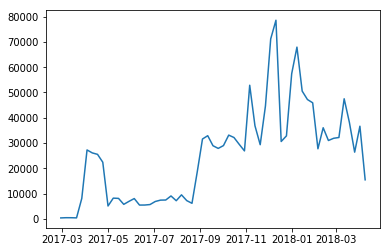

In [37]:
plt.plot(list(df_1['Date']), list(df_1['count']))

2. Use Bar chart to list top 10 websites by volume of mentions for News category and Blog & Forum categories respectively.
Note:
1. For the news, only one website in this dataset. 

In [ ]:
# top 10 blog_forum
df_10=df_2.loc[df_2['group'] =='blog_forum']
df_10['website'] = [1]*(len(df_10['Author']))
for i,url in zip(df_10.index,df_10['Url']):
    start = url.index('/') + 2
    end = url[start:].index('/')
    df_10.loc[i, 'website'] = url[start:start+end]
    # df_10.loc[i, 'website'] = url.split('/')[2]
top_10_blog_forum=df_10.groupby('website').agg({'Author': {'website_count': "count"}}).sort_values(by=[('Author', 'website_count')], ascending=False).head(10)
top_10_blog_forum['website'] = top_10_blog_forum.index

# top 10 news
df_11=df_2.loc[df_2['group'] =='news']
df_11['website'] = [1]*(len(df_11['Author']))
for i,url in zip(df_11.index,df_11['Url']):
    start = url.index('/') + 2
    end = url[start:].index('/')
    df_11.loc[i, 'website'] = url[start:start+end]
    # df_11.loc[i, 'website'] = url.split('/')[2]
top_10_news=df_11.groupby('website').agg({'Author': {'website_count': "count"}}).sort_values(by=[('Author', 'website_count')], ascending=False).head(10)
top_10_news['website'] = top_10_news.index

In [ ]:
##
x_blog_forum = list(top_10_blog_forum['website'])
a_blog_forum=list(top_10_blog_forum['Author']['website_count'])
x_pos_bf = [i for i, _ in enumerate(x_blog_forum)]

x_news = list(top_10_news['website'])
a_news=list(top_10_news['Author']['website_count'])
x_pos_news = [i for i, _ in enumerate(x_news)]

plt.subplot(1,2,1)
plt.bar(x_pos_bf, a_blog_forum, color='green')
plt.xlabel("website")
plt.xticks(x_pos_bf, tuple(x_blog_forum),rotation='vertical')
plt.ylabel("website_count")
plt.title("TOP 10 website_count for blog_forum")
##
plt.subplot(1,2,2)
plt.bar(x_pos_news, a_news, color='blue')
plt.xlabel("website")
plt.xticks(x_pos_news, tuple(x_news),rotation='vertical')
plt.ylabel("website_count")
plt.title("TOP 10 website_count for news")

## 3. Create a bubble chart to show the engagement weekly change in the Social category. The x-axis would be the week, the y-axis would be the percentage of positive mentions of the week, and the bubble size would be engagement.

In [38]:
df_15=df_2.loc[df_2['group']=='social']
df_15=df_15[(df_15['Date'].dt.year >= 2017)]
##date with engagment 
df_16=df_15[['Author','Date','Blog_Comments','Facebook_Comments','Facebook_Likes','Instagram_Likes','Instagram_Comments','Twitter_Retweets']]
mentions_bydate=df_16.groupby('Date').count()['Author']
df_16['count'] = [1]*(len(df_16['Author']))
df_16['Date'] = pd.to_datetime(df_16['Date']) - pd.to_timedelta(7, unit='d')
df_16 = df_16.groupby([pd.Grouper(key='Date', freq='W-MON')])['count'].sum().reset_index().sort_values('Date')

##date with percentage of positive mentions

df_17=df_15[['Author','Date','Sentiment']]
df_17.loc[df_17['Sentiment'] != 1.0, 'Sentiment'] = 0.0
df_17.loc[df_17['Sentiment'] == 1.0, 'Sentiment'] = 1.0
df_17['Date'] = pd.to_datetime(df_17['Date']) - pd.to_timedelta(7, unit='d')

aggregations = {
    'Sentiment': {'positive_sentiment_percentage': 'mean'}
}
df_17 = df_17.groupby([pd.Grouper(key='Date', freq='W-MON')]).agg(aggregations).reset_index().sort_values('Date')

Text(0.5,1,'bubble chart')

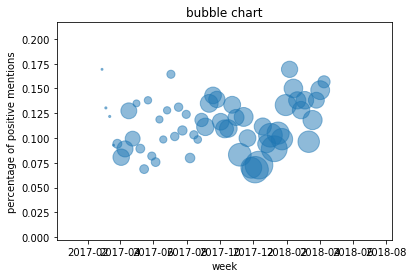

In [39]:
df_18=pd.merge(df_16, df_17, on='Date')
X = np.asarray(list(df_18['Date']))
a=[elem for elem in  list(df_18[('Sentiment', 'positive_sentiment_percentage')])]
Y=np.asarray(a)
Z= (np.asarray(list(df_18['count'])))/100
plt.scatter(x= X, y = Y, s=Z,alpha=0.5)
plt.xlabel("week")
plt.ylabel("percentage of positive mentions")
plt.title("bubble chart")